# Shap explanation of pipeline object: Numeric Features

In a ml project, when we have numeric features that we would like to impute or scale during pre-processing, we may nonetheless want the shap explanation to use the original (rather than preprocessed) feature values when explaining individual cases. For example, we would want to know that age==24 (rather than age==0.3668 🤪) adds 5% to the predicted probability of suivival. And this is easy-peasy 🍋 squeezy with `shap`.  

Below is minimal examples to achieve the goal and validate the result. As a bonus, Sklearn Pipeline is used to do the preprocessing. 

### Set up and dummy data

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [3]:
# create classification dataset
n_features = 10
n_informative = 5
n_redundant = 2
n_random = n_features - n_informative - n_redundant
X, y = make_classification(n_samples= 1000, n_features=n_features, n_informative=n_informative, 
                           n_redundant=n_redundant, shuffle = False, random_state = 42)
informative_names = [f'informative_{i+1}' for i in range(n_informative)]
redundant_names = [f'redundant_{i+n_informative+1}' for i in range(n_redundant)]
random_names = [f'random_{i+n_informative+n_redundant+1}' for i in range(n_random)]
feature_names = informative_names + redundant_names + random_names
X = pd.DataFrame(X.copy(), columns = feature_names)

# add missing values
missing_pct = 0.10
missing_mask = np.random.rand(*X.shape) < missing_pct
X_with_missing = X.copy()
X_with_missing[missing_mask] = np.nan


X_train, X_test, y_train, y_test = train_test_split(X_with_missing, y, test_size = 0.2)


### Pipeline object: Define and Train

Create a pipeline to do scaling, imputing and then modelling.

In [4]:
pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('classifier', RandomForestClassifier())
])

In [5]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('classifier', RandomForestClassifier())])

### Shap Explainer

Create an shap explainer based on the classifier in the pipeline. Note we need to pass in preprocessed data into the expaliner to create shap_values. 

In [6]:
# explainer = shap.Explainer(pipeline)
explainer = shap.Explainer(pipeline['classifier'])

In [16]:
# we need to do the transformation first then pass the data into explainer
X_test1 = pipeline['scalar'].transform(X_test)
X_test2 = pipeline['imputer'].transform(X_test1)
shap_values = explainer(X_test2)

In [17]:
# test whether the actual prediction == base_value + sum of shap values across features 
shap_df = pd.DataFrame(shap_values.values[:,:,1], columns = feature_names)
np.isclose(pipeline.predict_proba(X_test)[:,1], 
         shap_df.sum(axis=1) + shap_values.base_values[0][1])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Check out shap explanations

We can easily replace the data attribute in shap_values. Therefore, in explanation of individual cases, we get to see the original feature values! 

In [18]:
# Compare shap_value.data with X_test
pd.DataFrame(shap_values.data, columns = feature_names).equals(X_test.reset_index(drop=True))

False

In [ ]:
# replace the data attribute
X_test_ = X_test.reset_index(drop=True)
shap_values.data = X_test_

In [24]:
# Now again, compare shap_value.data with X_test
pd.DataFrame(shap_values.data, columns = feature_names).equals(X_test.reset_index(drop=True))

True

In [20]:
# check the location of missing values in the original X_test 
# and we can doublecheck with the individual explanations
mask = X_test.isna()
row_indices, col_indices = np.where(mask)
for row_idx, col_idx in zip(row_indices, col_indices):
    print(f"missing value at row {row_idx+1} and column {col_idx+1}")

missing value at row 1 and column 5
missing value at row 4 and column 1
missing value at row 4 and column 4
missing value at row 4 and column 9
missing value at row 6 and column 5
missing value at row 7 and column 7
missing value at row 9 and column 7
missing value at row 11 and column 2
missing value at row 11 and column 4
missing value at row 12 and column 2
missing value at row 12 and column 10
missing value at row 13 and column 9
missing value at row 14 and column 7
missing value at row 16 and column 5
missing value at row 17 and column 1
missing value at row 17 and column 8
missing value at row 18 and column 2
missing value at row 18 and column 7
missing value at row 19 and column 9
missing value at row 20 and column 2
missing value at row 20 and column 3
missing value at row 22 and column 5
missing value at row 23 and column 3
missing value at row 23 and column 7
missing value at row 23 and column 8
missing value at row 24 and column 10
missing value at row 25 and column 3
missin

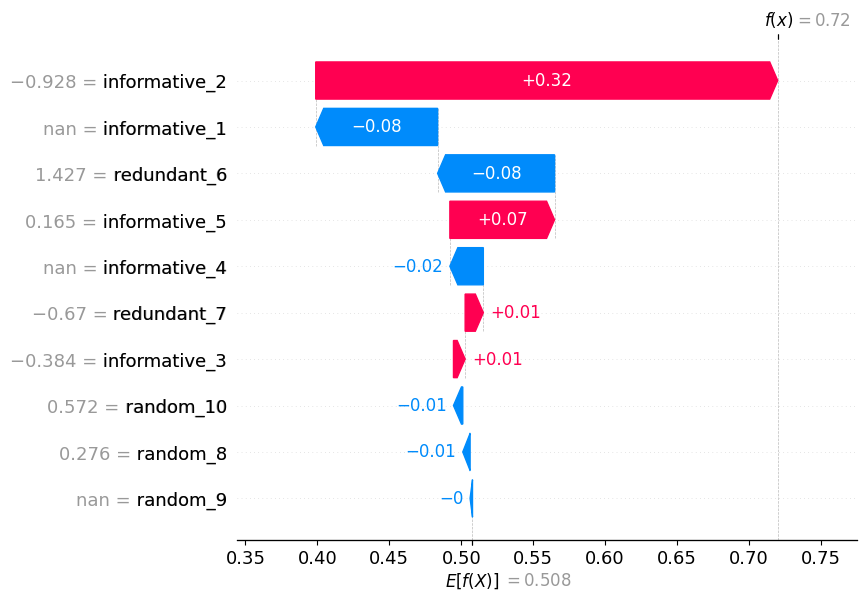

In [23]:
# Expalnation of case #1, original feature values are shown, including missing values
shap.plots.waterfall(shap_values[:,:,1][3])

## Discussions and what's next

The next experiment I would like to try out is about OneHotEncoding for categorical features. 